# Интенсив №3

#### Работа с выбранной моделью

Установка библиотек и их импорт

In [1]:
# Установка необходимых библиотек
%pip install pandas numpy matplotlib seaborn scikit-learn tensorflow

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split


Note: you may need to restart the kernel to use updated packages.


Работа с данными 1

In [2]:
# Загружаем данные
train_path = "train.xlsx"
train = pd.read_excel(train_path, header=0)

# Проверяем названия столбцов
print("Столбцы train:", train.columns.tolist())

# Убираем пробелы и приводим названия к нижнему регистру
train.columns = train.columns.str.strip().str.lower()

# Переименовываем колонки в стандартные названия
column_mapping = {'dt': 'date', 'цена на арматуру': 'price'}
train.rename(columns=column_mapping, inplace=True)

# Приводим столбец 'date' к типу datetime
train['date'] = pd.to_datetime(train['date'])
train.set_index('date', inplace=True)

Столбцы train: ['dt', 'Цена на арматуру']


Работа с данными 2

In [3]:
# Разделяем данные на тренировочную и тестовую выборки (80% / 20%)
train_data, test_data = train_test_split(train, test_size=0.2, shuffle=False)

# Нормализация данных
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data[['price']])
test_scaled = scaler.transform(test_data[['price']])

Подготовка данных для LSTM

In [4]:
def create_dataset(data, time_step=30):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:i + time_step])
        y.append(data[i + time_step])
    return np.array(X), np.array(y)

time_step = 30  # Размер окна для LSTM
X_train, y_train = create_dataset(train_scaled, time_step)
X_test, y_test = create_dataset(test_scaled, time_step)


Изменение формы данных для LSTM

In [5]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

Создание модели LSTM

In [6]:
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(time_step, 1)),
    LSTM(50, return_sequences=False),
    Dense(25),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

# Обучение модели
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

c:\Users\b1gtz\Desktop\IT Projects\Python\Intensive 3\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - loss: 0.0484 - val_loss: 0.0462
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0117 - val_loss: 0.0594
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0129 - val_loss: 0.0439
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0085 - val_loss: 0.0406
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0094 - val_loss: 0.0387
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0093 - val_loss: 0.0443
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0082 - val_loss: 0.0374
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0082 - val_loss: 0.0381
Epoch 9/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0080 - val_loss: 0.0390
Epoch 10/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0057 - val_loss: 0.0346
Epoch 11/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0065 - val_loss: 0.0335
Epoch 12/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0

Предсказания на тестовой выборке, оценка и визуализация предсказаний

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
LSTM Test MAE: 2458.6488281250004


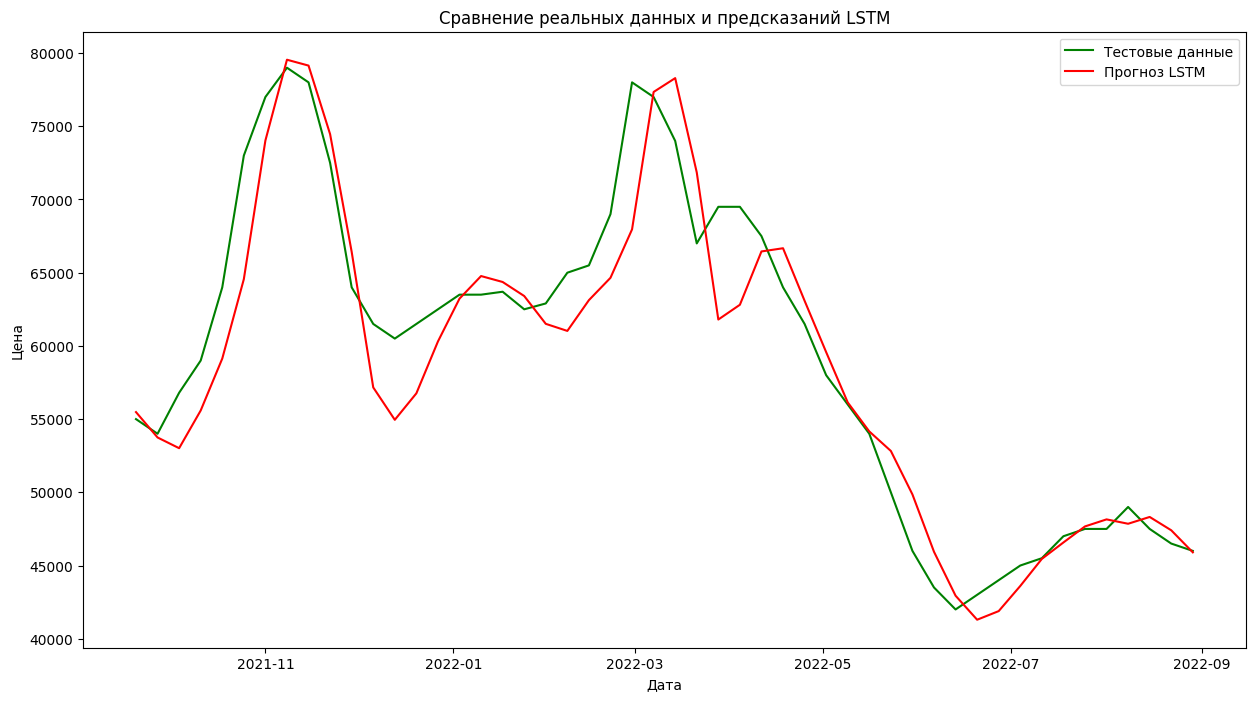

In [7]:
# Предсказания
test_preds_lstm = model.predict(X_test)
test_preds_lstm_rescaled = scaler.inverse_transform(test_preds_lstm)  # Обратное преобразование
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Оценка модели
lstm_mae = mean_absolute_error(y_test_rescaled, test_preds_lstm_rescaled)
print(f'LSTM Test MAE: {lstm_mae}')

# Визуализация предсказаний
plt.figure(figsize=(15, 8))
plt.plot(test_data.index[time_step:], y_test_rescaled, label='Тестовые данные', color='green')
plt.plot(test_data.index[time_step:], test_preds_lstm_rescaled, label='Прогноз LSTM', color='red')
plt.title('Сравнение реальных данных и предсказаний LSTM')
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.legend()
plt.show()

### Разложение временного ряда

Установка и импорт библиотек

In [8]:
%pip install pandas numpy matplotlib seaborn statsmodels

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL

Note: you may need to restart the kernel to use updated packages.


Работа с данными

In [9]:
# Загружаем данные
train_path = "train.xlsx"
train = pd.read_excel(train_path, header=0)

# Проверяем названия столбцов
print("Столбцы train:", train.columns.tolist())

# Убираем пробелы и приводим названия к нижнему регистру
train.columns = train.columns.str.strip().str.lower()

# Переименовываем колонки в стандартные названия
column_mapping = {'dt': 'date', 'цена на арматуру': 'price'}
train.rename(columns=column_mapping, inplace=True)

# Приводим столбец 'date' к типу datetime
train['date'] = pd.to_datetime(train['date'])
train.set_index('date', inplace=True)

Столбцы train: ['dt', 'Цена на арматуру']


Временной ряд

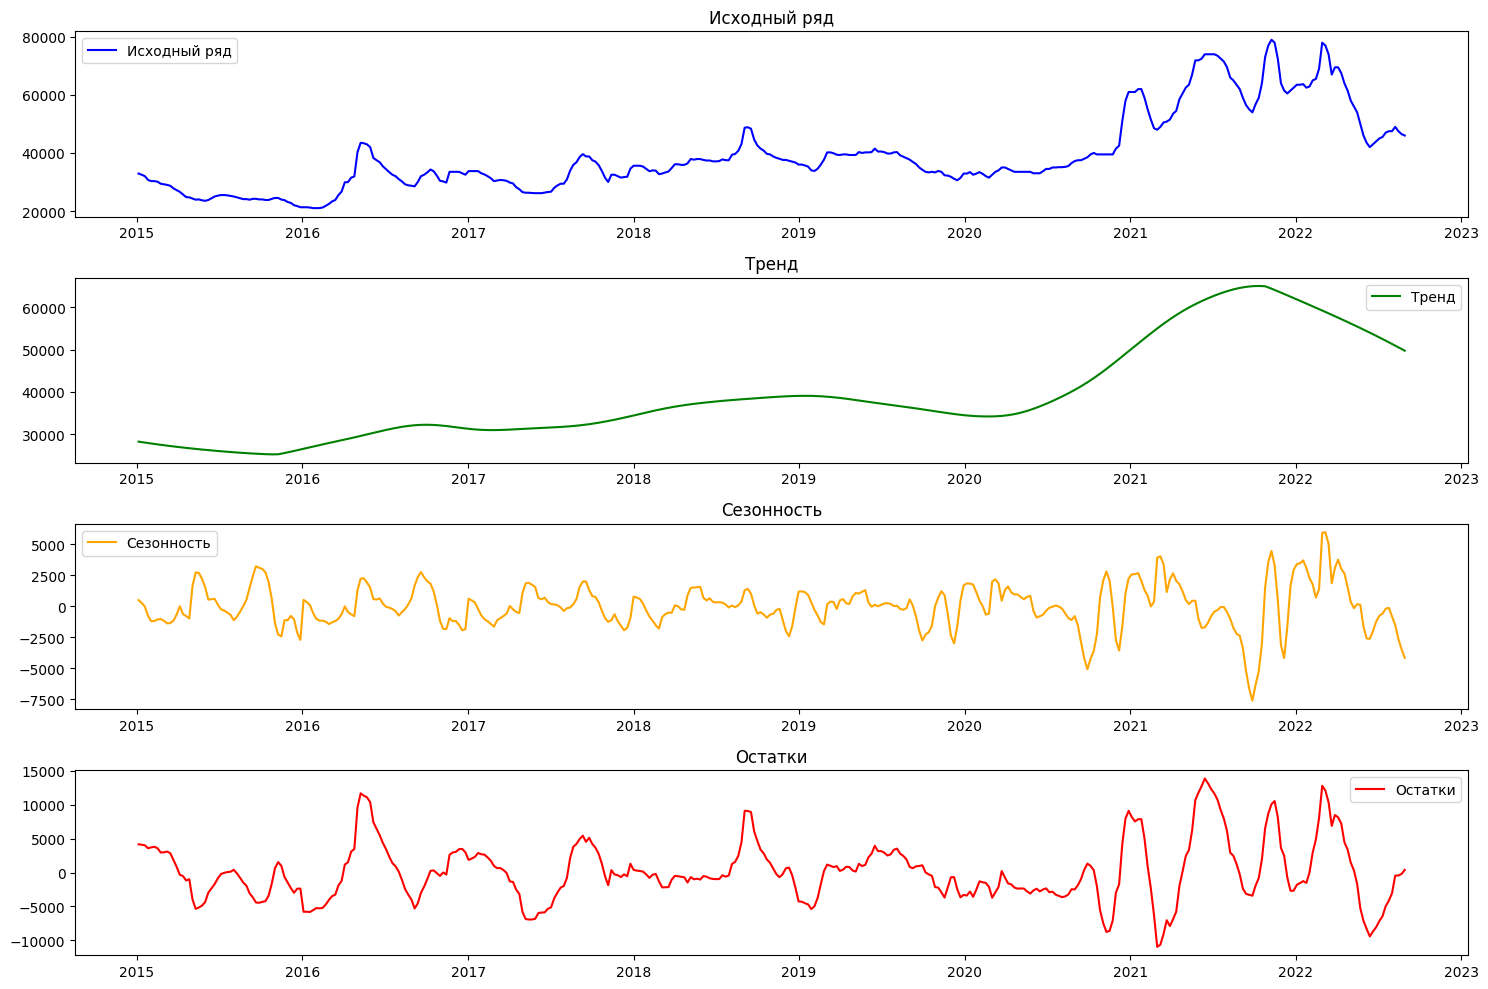

In [10]:
# Разложение временного ряда на тренд, сезонность и остатки
stl = STL(train['price'], seasonal=13)  # seasonal=13 — параметр для еженедельной сезонности
result = stl.fit()

# Извлекаем компоненты
trend = result.trend
seasonal = result.seasonal
residual = result.resid

# Визуализация разложения
plt.figure(figsize=(15, 10))

plt.subplot(4, 1, 1)
plt.plot(train.index, train['price'], label='Исходный ряд', color='blue')
plt.title('Исходный ряд')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(train.index, trend, label='Тренд', color='green')
plt.title('Тренд')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(train.index, seasonal, label='Сезонность', color='orange')
plt.title('Сезонность')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(train.index, residual, label='Остатки', color='red')
plt.title('Остатки')
plt.legend()

plt.tight_layout()
plt.show()

Превидение к стационарному ряду


In [11]:
%pip install statsmodels

Note: you may need to restart the kernel to use updated packages.


p-value до преобразования: 0.3199906102569917
p-value после 1-го дифференцирования: 1.300693837380985e-11
p-value до преобразования: 0.9990041630645609
p-value после 1-го дифференцирования: 0.3253464458511689
p-value после 2-го дифференцирования: 0.625192270759954


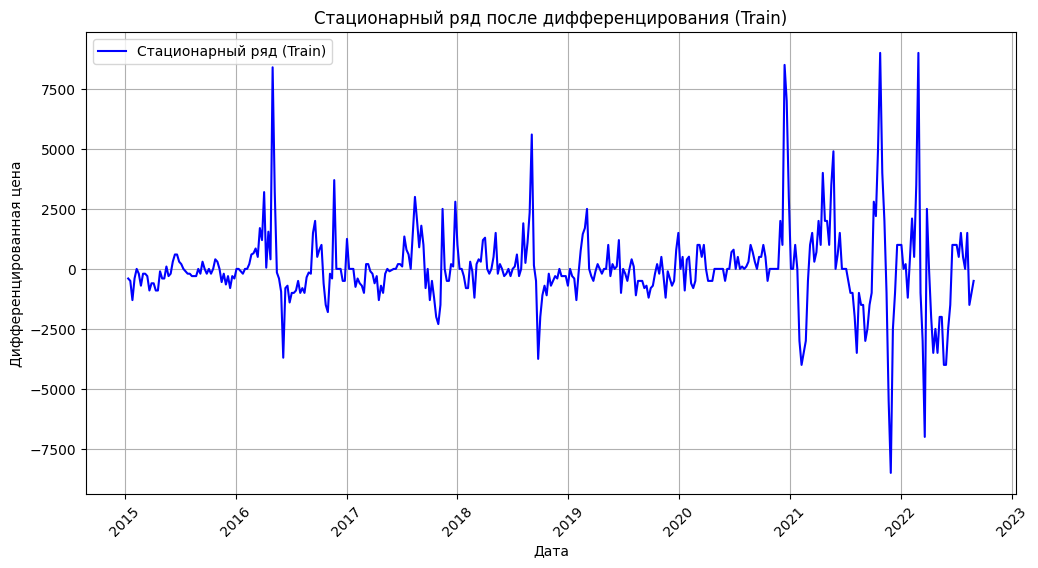

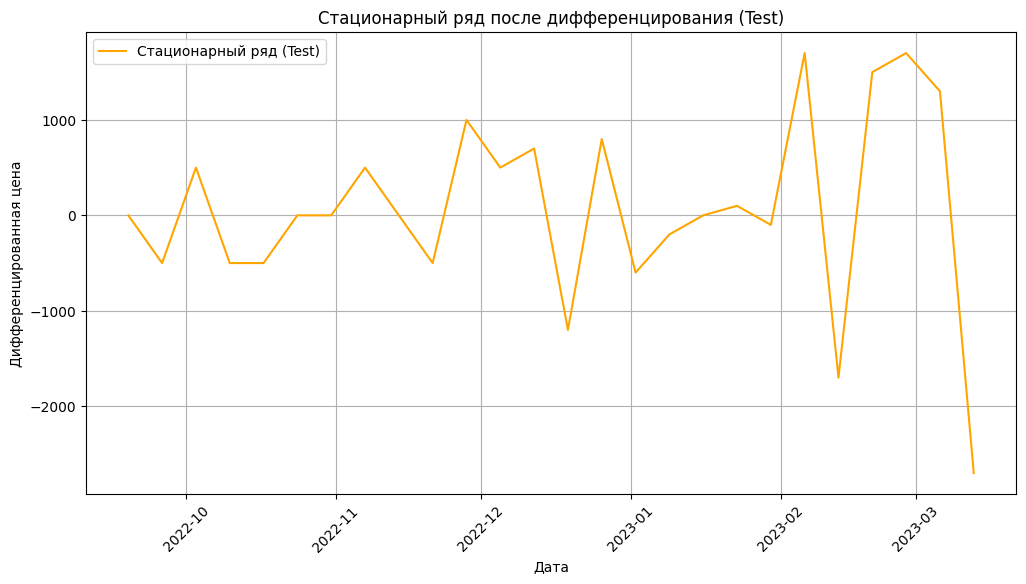

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

# Функция для приведения ряда к стационарному виду
def make_stationary(series):
    # Проверяем изначальную стационарность ряда
    result = adfuller(series.dropna())
    print(f'p-value до преобразования: {result[1]}')

    if result[1] > 0.05:  # Если ряд нестационарный
        diff_series = series.diff().dropna()
        result_diff = adfuller(diff_series)
        print(f'p-value после 1-го дифференцирования: {result_diff[1]}')

        if result_diff[1] > 0.05:  # Если после 1-го дифференцирования не стало стационарным
            diff_series = diff_series.diff().dropna()
            result_diff2 = adfuller(diff_series)
            print(f'p-value после 2-го дифференцирования: {result_diff2[1]}')
            return diff_series
        return diff_series
    return series

# Загрузка данных
train_df = pd.read_excel('train.xlsx')
test_df = pd.read_excel('test.xlsx')

# Преобразование столбца с датами в формат datetime
train_df.iloc[:, 0] = pd.to_datetime(train_df.iloc[:, 0])
test_df.iloc[:, 0] = pd.to_datetime(test_df.iloc[:, 0])

# Выбор столбца с ценами
train_prices = train_df['Цена на арматуру']
test_prices = test_df['Цена на арматуру']

# Приведение к стационарному ряду
train_prices_stationary = make_stationary(train_prices)
test_prices_stationary = make_stationary(test_prices)

# Коррекция длины данных после дифференцирования
train_dates = train_df.iloc[len(train_df) - len(train_prices_stationary):, 0]  
test_dates = test_df.iloc[len(test_df) - len(test_prices_stationary):, 0]

# График для train с корректной осью X
plt.figure(figsize=(12, 6))
plt.plot(train_dates, train_prices_stationary, label='Стационарный ряд (Train)', color='blue')
plt.xlabel('Дата')
plt.ylabel('Дифференцированная цена')
plt.title('Стационарный ряд после дифференцирования (Train)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

# График для test с корректной осью X
plt.figure(figsize=(12, 6))
plt.plot(test_dates, test_prices_stationary, label='Стационарный ряд (Test)', color='orange')
plt.xlabel('Дата')
plt.ylabel('Дифференцированная цена')
plt.title('Стационарный ряд после дифференцирования (Test)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()
